In [84]:
# import libraries
import pandas as pd
import dask.dataframe as dd
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [85]:
# load client and invoice datasets
client_train = pd.read_csv('data/client_train.csv')
client_test = pd.read_csv('data/client_test.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [86]:
# merge client and invoice training and testing dataset
merged_df = pd.merge(invoice_train, client_train, on='client_id', how='inner')

merged_test = pd.merge(invoice_test, client_test, on='client_id', how='inner')

In [87]:
from sklearn.preprocessing import LabelEncoder

# Define the list of categorical columns
categorical_columns = ['disrict', 'client_catg', 'region', 'tarif_type', 
                       'counter_statue', 'reading_remarque', 'counter_type']

# Apply Label Encoding to each categorical feature
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # Convert to string in case there are mixed types
    label_encoders[col] = le  # Store the encoder for potential inverse_transform

# Verify the encoding
print(merged_df[categorical_columns].head())

   disrict  client_catg  region  tarif_type  counter_statue  reading_remarque  \
0        0            0       0           1               0                 6   
1        0            0       0           1               0                 4   
2        0            0       0           1               0                 6   
3        0            0       0           1               0                 6   
4        0            0       0           1               0                 7   

   counter_type  
0             0  
1             0  
2             0  
3             0  
4             0  


Fraud detection data contains categorical features (e.g., district, client category). Machine learning models like kNN require numerical inputs so label encoding was used to convert these categorical features into numerical representations without introducing ordinal relationships (since the categories aren't inherently ordered), which ensures that the data can be utilized effectively by the kNN algorithm.

In [88]:
features = [
    'tarif_type', 'counter_number', 'counter_code', 'reading_remarque',
    'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index',
    'months_number', 'disrict', 'client_catg', 'region', 'counter_statue', 'counter_type'
]

In [89]:
from sklearn.model_selection import train_test_split

# Partion the features from the class to predict
df_X = merged_df[features]
df_y = merged_df['target'].astype(int)  # Convert 'target' to integer (1/0)  # Convert 'Fraud'/'Not Fraud' to 1/0

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=1)

print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  3133724 
Number of test instances:  1343025


In [90]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kNN relies on distance metrics (e.g., Euclidean, Manhattan). Features with large scales can dominate the distance calculations. StandardScaler was applied to normalize features to have zero mean and unit variance. Standardization prevents bias due to differing feature scales and improves the accuracy of distance-based methods like kNN.

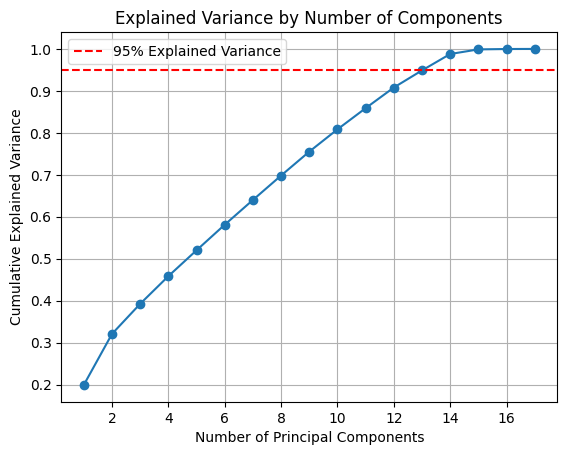

In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the full dataset or a sample
pca = PCA().fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# Apply PCA with a fixed number of components 
pca = PCA(n_components=13, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components: {X_train_pca.shape[1]}")

Number of PCA components: 13


High-dimensional data can cause the "curse of dimensionality," making distances less meaningful and increasing computational complexity.
PCA reduces the dimensionality while retaining 95% of the variance in the data. Reducing the number of features improves kNN's runtime efficiency without significantly sacrificing predictive performance. PCA also helps in identifying latent patterns and makes the data more compact, aiding in better model performance.

In [93]:
# Check the class distribution in the training set
print("Number of training instances: ")
print(len(X_train_pca))

class_distribution = y_train.value_counts(normalize=True)

print("Class distribution in the training set:")
print(class_distribution)


Number of training instances: 
3133724
Class distribution in the training set:
target
0    0.92107
1    0.07893
Name: proportion, dtype: float64


In [94]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("Number of training instances after SMOTE: ")
print(len(X_train_resampled))

print("Class distribution in resampled training set:")
print(y_train_resampled.value_counts(normalize=True))

Number of training instances after SMOTE: 
5772760
Class distribution in resampled training set:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


Fraud detection datasets are typically imbalanced, with far fewer fraud cases (minority class) compared to non-fraud cases (majority class).
Imbalanced datasets lead to models that are biased toward predicting the majority class. SMOTE (Synthetic Minority Oversampling Technique) creates synthetic examples of the minority class to balance the dataset, ensuring the model has sufficient examples of fraud cases to learn patterns effectively. Balancing the dataset improves metrics like F1-score and Recall, which are critical in fraud detection (catching fraudulent cases is more important than overall accuracy).

In [95]:
# Take a 5% sample of the training data for tuning
sample_size = int(0.05 * len(X_train_resampled))
sample_indices = np.random.choice(len(X_train_resampled), sample_size, replace=False)
X_sample = X_train_resampled[sample_indices]
y_sample = y_train_resampled.iloc[sample_indices]

In [96]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

# Define the metrics and the number of trials per metric
metrics = ['manhattan', 'euclidean', 'chebyshev']
trials_per_metric = 10  # Number of trials for each metric
total_trials = len(metrics) * trials_per_metric

def objective(trial):
    # Manually assign a metric based on trial number
    metric_idx = trial.number % len(metrics)
    metric = metrics[metric_idx]

    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    trial.set_user_attr("metric", metric)

    knn = neighbors.KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        weights='distance'
    )
    
    score = cross_val_score(knn, X_sample, y_sample, cv=3, scoring='f1_weighted').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=total_trials, n_jobs=-1)

best_trial = study.best_trial
best_metric = best_trial.user_attrs["metric"]

print("Best parameters:", study.best_params)
print("Best metric:", best_metric)
print("Best cross-validation F1-score:", study.best_value)

[I 2024-11-20 18:48:10,428] A new study created in memory with name: no-name-1b72f76f-ccfb-4f0b-b17e-76f740bcaa52
[I 2024-11-20 18:48:21,521] Trial 2 finished with value: 0.668090860758428 and parameters: {'n_neighbors': 1}. Best is trial 2 with value: 0.668090860758428.
[I 2024-11-20 18:48:36,289] Trial 5 finished with value: 0.6664749524529676 and parameters: {'n_neighbors': 9}. Best is trial 2 with value: 0.668090860758428.
[I 2024-11-20 18:48:38,022] Trial 8 finished with value: 0.6667743151968835 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 0.668090860758428.
[I 2024-11-20 18:49:06,151] Trial 3 finished with value: 0.6653218224241677 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 0.668090860758428.
[I 2024-11-20 18:49:09,136] Trial 1 finished with value: 0.666369446639597 and parameters: {'n_neighbors': 17}. Best is trial 2 with value: 0.668090860758428.
[I 2024-11-20 18:49:12,318] Trial 4 finished with value: 0.666369446639597 and parameters: {

Best parameters: {'n_neighbors': 1}
Best metric: euclidean
Best cross-validation F1-score: 0.6688230543039136


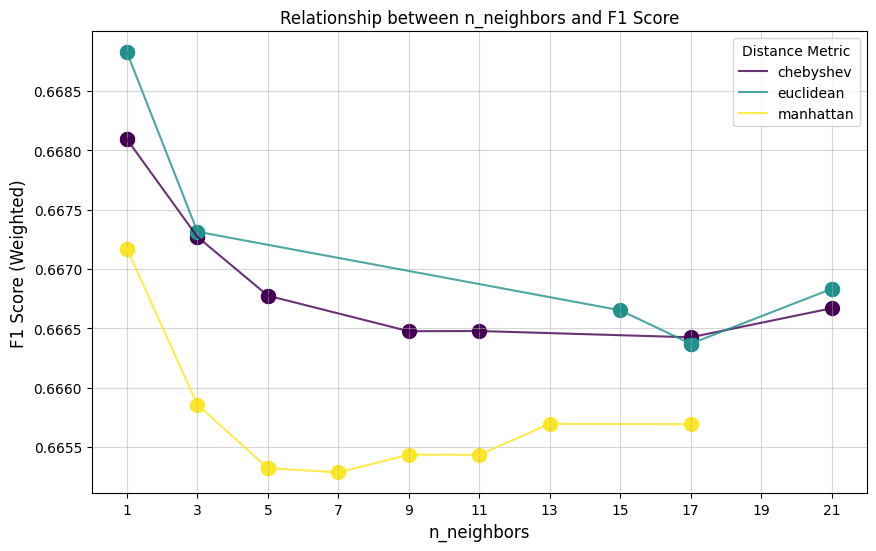

In [97]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

# Extract n_neighbors, F1 scores, and metric values for each trial
n_neighbors_values = [trial.params['n_neighbors'] for trial in study.trials if trial.value is not None]
f1_scores = [trial.value for trial in study.trials if trial.value is not None]
metrics = [trial.user_attrs['metric'] for trial in study.trials if trial.value is not None]  # Fetch 'metric' from user_attrs

# Define unique colors for each metric using viridis
unique_metrics = sorted(set(metrics))  # Sorted for consistent ordering
colors = [to_hex(viridis(i / (len(unique_metrics) - 1))) for i in range(len(unique_metrics))]  # Assign distinct colors
color_map = dict(zip(unique_metrics, colors))

unique_n_neighbors = sorted(set(n_neighbors_values))
x_ticks = list(range(min(unique_n_neighbors), max(unique_n_neighbors) + 2, 2)) 

plt.figure(figsize=(10, 6))
for metric in unique_metrics:
    # Filter data for the current metric
    metric_indices = [i for i, m in enumerate(metrics) if m == metric]
    n_neighbors_metric = [n_neighbors_values[i] for i in metric_indices]
    f1_scores_metric = [f1_scores[i] for i in metric_indices]

    # Sort the points by n_neighbors for a smooth line
    sorted_indices = sorted(range(len(n_neighbors_metric)), key=lambda k: n_neighbors_metric[k])
    n_neighbors_metric = [n_neighbors_metric[i] for i in sorted_indices]
    f1_scores_metric = [f1_scores_metric[i] for i in sorted_indices]

    # Plot line and scatter points
    plt.plot(
        n_neighbors_metric,
        f1_scores_metric,
        label={metric},
        color=color_map[metric],
        linestyle='-',
        alpha=0.8
    )
    plt.scatter(
        n_neighbors_metric,
        f1_scores_metric,
        color=color_map[metric],
        s=100, 
    )

plt.legend(title="Distance Metric", loc="best")

# Format plot
plt.xticks(x_ticks, fontsize=10)  # Set evenly spaced x-axis ticks
plt.yticks(fontsize=10)
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('F1 Score (Weighted)', fontsize=12)
plt.title('Relationship between n_neighbors and F1 Score')
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

kNN has key hyperparameters like n_neighbors (number of neighbors) and metric (distance measure). The performance of kNN is highly sensitive to these choices. Optuna was used to automate the hyperparameter tuning process by maximizing the F1-weighted score through cross-validation. Automated tuning ensures the model achieves its best performance without manual trial and error. The use of cross-validation ensures that the chosen hyperparameters generalize well to unseen data.

In [98]:
# train the KNN model with the optimized hyperparameters
best_trial = study.best_trial
best_metric = best_trial.user_attrs["metric"]

knn_model = neighbors.KNeighborsClassifier(
    n_neighbors=best_trial.params['n_neighbors'],  
    metric=best_metric, 
    weights='distance',
    n_jobs=-1  # Use all CPU cores for faster computation
)

knn_model.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=1,
                     weights='distance')

In [99]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test_pca)

In [100]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1013134  224123]
 [  66701   39067]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87   1237257
           1       0.15      0.37      0.21    105768

    accuracy                           0.78   1343025
   macro avg       0.54      0.59      0.54   1343025
weighted avg       0.88      0.78      0.82   1343025



Fraud detection requires evaluating both macroscopic (dataset-wide) and microscopic (instance-level) performance. Metrics like Precision, Recall, and F1-score are critical, especially for the minority class (fraud cases). The confusion matrix provides insight into False Positives (incorrectly classified non-fraud cases) and False Negatives (missed fraud cases).

The kNN model for fraud detection demonstrates reasonable performance as a baseline approach, achieving an overall accuracy of 78%. However, the model struggles with the minority class (fraudulent cases), achieving a low precision of 15% and recall of 38%, resulting in a modest F1-score of 0.21 for fraud detection. While the model performs well in identifying non-fraudulent cases, with a precision of 94% and recall of 82%, it misses a significant proportion of fraudulent instances, which are critical in fraud detection tasks. 

Despite addressing class imbalance with SMOTE and optimizing hyperparameters, the model's high false negative rate indicates challenges in distinguishing fraudulent patterns. This evaluation highlights the need for further improvement through advanced feature engineering, alternative algorithms, and threshold adjustments to enhance the model's recall and overall effectiveness in fraud detection.